In [4]:
import sys
sys.path.append("..")
import datetime

from src.helper import make_ts

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

## 3.1 Simple forecasting methods

### Average Method:

The forecasts of all future values are equal to the average of the historical data:


$\hat{y}_{T+h|T}=\bar{y}=(y_{1}+..+y_{T})/T$

In [3]:
ts_df = make_ts('2000',20)

In [4]:
ts_df.head()

,Observation
Date,
2000-01-01,68.094189
2001-01-01,9.832942
2002-01-01,33.767775
2003-01-01,63.871356
2004-01-01,7.727545


In [5]:
def average_forecast(y, h):
    """
    y = time series index of pandas data frame
    h = forecast horizon
    
    TODO: Move to helper.py. 
    """
    ts = pd.DataFrame(pd.date_range(
                                        str(ts_df.index[-1] + datetime.timedelta(days=365)), 
                                        periods = h, 
                                        freq=pd.infer_freq(y.index)
                                        ), 
                      columns = ['Date']
                     )
    ts['Forecast_AVG'] = y['Observation'].mean()
    ts.set_index('Date', inplace = True)
    return ts

In [6]:
forecast_avg = average_forecast(ts_df, 10)

## Naïve method

The forecasts of all future values are equal to the average of the historical data:


$\hat{y}_{T+h|T}=y_{T}$

In [7]:
def naive_forecast(y, h):
    """
    y = time series index of pandas data frame
    h = forecast horizon
    
    TODO: Move to helper.py. 
    """
    ts = pd.DataFrame(pd.date_range(
                                        str(ts_df.index[-1] + datetime.timedelta(days=365)), 
                                        periods = h, 
                                        freq=pd.infer_freq(y.index)
                                        ), 
                      columns = ['Date']
                     )
    ts['Forecast_Naive'] = y['Observation'][-1]
    ts.set_index('Date', inplace = True)
    return ts

In [8]:
forecast_naive = naive_forecast(ts_df, 10)

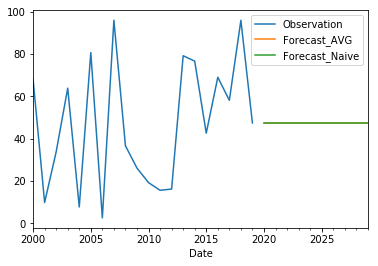

In [9]:
fig, ax = plt.subplots()
ts_df.plot(ax = ax)
forecast_avg.plot(ax = ax)
forecast_naive.plot(ax=ax)

In [138]:
seasonal = make_ts("2000", 12*20, 'M')

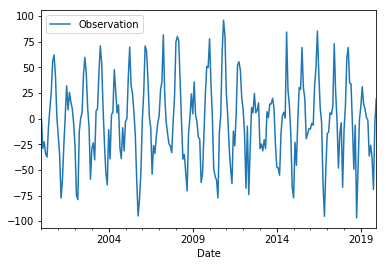

In [139]:
seasonal.plot()

In [140]:
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [150]:
def s_naive_forecast(y, h):
    """
    y = time series index of pandas data frame
    h = forecast horizon
    
    TODO: Move to helper.py. 
    """
    ts = pd.DataFrame(pd.date_range(
                                        str(ts_df.index[-1] + datetime.timedelta(days=365)), 
                                        periods = h, 
                                        freq=pd.infer_freq(y.index)
                                        ), 
                      columns = ['Date']
                     )
    history = [x for x in y['Observation']]
    prediction = []
    
    for i in range(periods):
        predict = float(SARIMAX(history,
                            order = (0,0,0),
                            seasonal_order=(0,1,0,12)).fit(disp=0).forecast()[0]
                       )
    
        history.append(predict)
        prediction.append(predict)
    prediction = pd.Series(prediction)
    ts = pd.concat((ts,prediction), axis = 1)
    ts.columns = ['Date', 'Forecast']
    ts.set_index('Date', inplace = True)
    return ts

In [151]:
s_naive =s_naive_forecast(seasonal, 12*5)

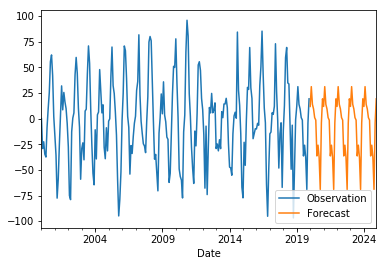

In [152]:
fig, ax = plt.subplots()
seasonal.plot(ax = ax)
s_naive.plot(ax = ax)

## 3.2 Transofmrations and Adjustments

#### Python datetime curioisty

In [33]:
datetime.datetime.strptime('31-Dec-68', '%d-%b-%y').date()

datetime.date(2068, 12, 31)

In [34]:
datetime.datetime.strptime('1-Jan-69', '%d-%b-%y').date()

datetime.date(1969, 1, 1)

Python has a rollover in datetime where if the year is YY then before 69 is assumed to be 20YY while if YY is 69 or later it is assumed to be 19YY.
See more: https://stackoverflow.com/questions/37766353/pandas-to-datetime-parsing-wrong-year?answertab=votes#tab-top

#### Calendar Adjustments

In [47]:
milk = pd.read_csv("../data/milk.csv")

In [48]:
milk['index'] = pd.to_datetime(milk['index'])

In [51]:
milk['days']= milk['index'].dt.daysinmonth

In [52]:
milk.set_index('index', inplace = True)

In [54]:
milk['daily_average'] = milk['value']/milk['days']

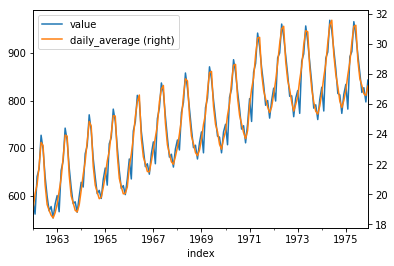

In [60]:
milk[['value', 'daily_average']].plot(secondary_y = ['daily_average'])

#### Mathematical Transformations

#### Box-Cox transformations

Box-cox is useful for transforming data so it is closer to normal

$w_{t} = (y_{t}^{\lambda} - 1) / \lambda,  for \lambda > 0$

$w_{t} = \ln{y_{t}},                       for \lambda = 0$

where $w_{t}$ is the transformed data

In [62]:
from scipy import stats

In [66]:
elec = pd.read_csv("../data/elec.csv")

In [68]:
elec.head()

,index,value
0,1/1/1956,1254
1,2/1/1956,1290
2,3/1/1956,1379
3,4/1/1956,1346
4,5/1/1956,1535


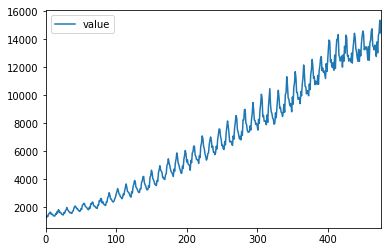

In [67]:
elec.plot()

In [73]:
elec['transformed'], lmbda = stats.boxcox(elec['value'])

In [74]:
elec['index'] = pd.to_datetime(elec['index'])

In [75]:
elec.set_index('index', inplace = True)

Value transformed with box-cox transformation with lambda = 0.3896252474492478


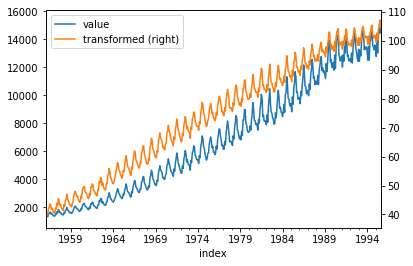

In [80]:
elec.plot(secondary_y = ['transformed'])
print('Value transformed with box-cox transformation with lambda = {}'.format(lmbda))